One advantage of ***coding to interfaces*** is that you can create `multiple
implementations` of a service.

In [ ]:
public interface IMessageSender
{
    public void SendMessage(string message);
}

you can impelment this interface for `SMS`, `Email`, `Facebook` and ...

### Injecting multiple implementations of an interface

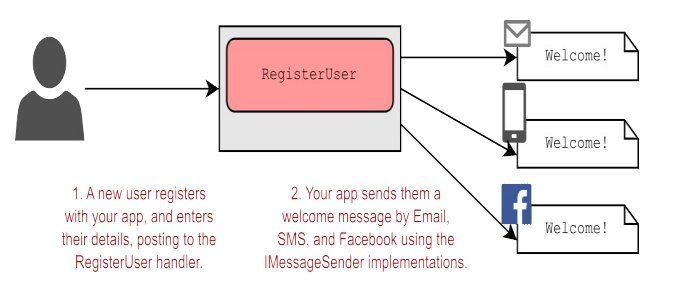

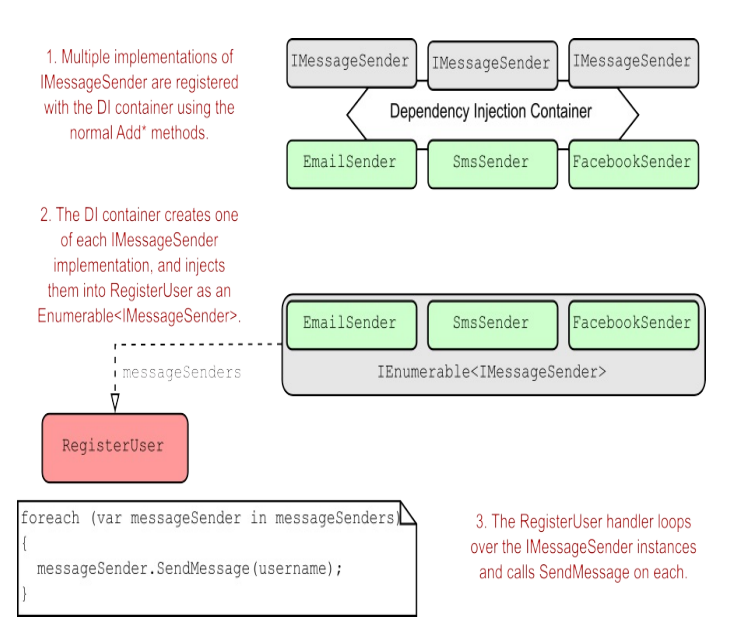

In [ ]:
WebApplicationBuilder builder = WebApplication.CreateBuilder(args);
builder.Services.AddScoped<IMessageSender, EmailSender>();
builder.Services.AddScoped<IMessageSender, SmsSender>();
builder.Services.AddScoped<IMessageSender, FacebookSender>();

var app= builder.Build();

string RegisterUser(
    string username,
    IEnumerable<IMessageSender> senders)
{
    foreach(var sender in senders)
    {
        sender.SendMessage($"Hello {username}!");
    }
    return $"Welcome message sent to {username}";
}


### Injecting a single implementation when multiple services are registered

In [ ]:
public class SingleMessageSender
{
    private readonly IMessageSender _messageSender;
    public SingleMessageSender(IMessageSender messageSender) 
    {
        _messageSender = messageSender;
    }
}
// witch impelementation select to send message?

It does this by using the `last registered implementation`: ***FacebookSender*** from the previous example

<div dir="rtl" style="margin:auto; width:90%; font-family:vazirmatn;">
<h5>ثبت مشروط سرویس‌ها (Conditional Registration)</h5>
<p>گاهی اوقات، شما ممکن است بخواهید یک پیاده‌سازی از یک سرویس را فقط در صورتی ثبت کنید که هنوز هیچ پیاده‌سازی دیگری از آن سرویس در کانتینر DI (ابزار مدیریت وابستگی‌ها) ثبت نشده باشد. این روش به‌ویژه برای نویسندگان کتابخانه‌ها (Libraries) مفید است. به این صورت که آن‌ها می‌توانند یک پیاده‌سازی پیش‌فرض از یک رابط (Interface) ایجاد کنند و آن را فقط در صورتی ثبت کنند که کاربر (برنامه‌نویس) قبلاً پیاده‌سازی خاص خودش را ثبت نکرده باشد.</p>

<h5>استفاده از متدهای TryAdd</h5>
<p>در فضای نام <strong><code>Microsoft.Extensions.DependencyInjection.Extensions</code></strong> چندین متد الحاقی (Extension Methods) برای ثبت مشروط سرویس‌ها وجود دارد، مانند <strong><code>TryAddScoped</code></strong>. این متد ابتدا بررسی می‌کند که آیا یک سرویس قبلاً در کانتینر DI ثبت شده است یا خیر. اگر ثبت نشده باشد، سپس آن سرویس را با استفاده از <strong><code>AddScoped</code></strong> ثبت می‌کند.</p>
</div>

In [ ]:
WebApplicationBuilder builder = WebApplication.CreateBuilder(args);
builder.Services.AddScoped<IMessageSender, EmailSender>(); 
builder.Services.TryAddScoped<IMessageSender, SmsSender>();

<div dir="rtl" style="margin:auto; width:90%; font-family:vazirmatn;">
<p>گاهی اوقات ممکن است بخواهید یک پیاده‌سازی که قبلاً در کانتینر DI ثبت شده است را با یک پیاده‌سازی جدید جایگزین کنید. برای این کار می‌توانید از متد <strong><code>Replace()</code></strong> استفاده کنید. با این حال، API این متد به اندازه متدهای <strong><code>TryAdd</code></strong> کاربرپسند نیست.</p>
</div>

In [ ]:
builder.Services.Replace(new ServiceDescriptor(
    typeof(IMessageSender), typeof(SmsSender), ServiceLifetime.Scoped
));


<div dir="rtl" style="margin:auto; width:90%; font-family:vazirmatn;">
<ul><li><strong><code>typeof(IMessageSender)</code></strong>: مشخص می‌کند که نوع سرویس <strong><code>IMessageSender</code></strong> باید جایگزین شود.</li><li><strong><code>typeof(SmsSender)</code></strong>: مشخص می‌کند که پیاده‌سازی جدید باید <strong><code>SmsSender</code></strong> باشد.</li><li><strong><code>ServiceLifetime.Scoped</code></strong>: طول عمر سرویس را مشخص می‌کند.</li></ul>
</div>

### Choose one implementation

In [ ]:
builder.Services.AddScoped<EmailSender>();
builder.Services.AddScoped<SMSSender>();
builder.Services.AddScoped<FacebookSender>();

In [ ]:
public class MessageSenderFactory
{
    private readonly IServiceProvider _serviceProvider;

    public MessageSenderFactory(IServiceProvider serviceProvider)
    {
        _serviceProvider = serviceProvider;
    }

    public IMessageSender CreateMessageSender(string type)
    {
        return type switch
        {
            "SMS" => _serviceProvider.GetRequiredService<SMSSender>(),
            "Email" => _serviceProvider.GetRequiredService<EmailSender>(),
            "Facebook" => _serviceProvider.GetRequiredService<FacebookSender>(),
            _ => throw new ArgumentException("Invalid message sender type"),
        };
    }
}

In [ ]:
builder.Services.AddSingleton<MessageSenderFactory>();

In [ ]:
public class NotificationService
{
    private readonly MessageSenderFactory _messageSenderFactory;

    public NotificationService(MessageSenderFactory messageSenderFactory)
    {
        _messageSenderFactory = messageSenderFactory;
    }

    public void SendNotification(string message, string type)
    {
        var sender = _messageSenderFactory.CreateMessageSender(type);
        sender.SendMessage(message);
    }
}

### Delegate Strategy

In [ ]:
public delegate IMessageSender StrategyMessageSender(string senderType);
//we can use enum instead of string

In [ ]:
builder.Services.AddScoped<StrategyMessageSender>(provider => (type) =>
{
    return type switch
    {
        "SMS" => provider.GetRequiredService<SMSSender>(),
        "Email" => provider.GetRequiredService<EmailSender>(),
        "Facebook" => provider.GetRequiredService<FacebookSender>(),
        _ => throw new ArgumentException("Invalid message sender type"),
    };
})

In [ ]:
public class NotificationService
{
    private readonly StrategyMessageSender _strategyMessageSender;

    public NotificationService(StrategyMessageSender strategyMessageSender)
    {
        _strategyMessageSender = strategyMessageSender;
    }

    public void SendNotification(string message, string type)
    {
        var sender = _strategyMessageSender.Invoke(type);
        sender.SendMessage(message);
    }
}

### Func Strategy

In [ ]:
builder.Services.AddScoped<Func<string, IMessageSender>>(provider => (type) =>
{
    return type switch
    {
        "SMS" => provider.GetRequiredService<SMSSender>(),
        "Email" => provider.GetRequiredService<EmailSender>(),
        "Facebook" => provider.GetRequiredService<FacebookSender>(),
        _ => throw new ArgumentException("Invalid message sender type"),
    };
});

In [ ]:
public class NotificationService
{
    private readonly Func<string, IMessageSender> _strategyMessageSender;

    public NotificationService(Func<string, IMessageSender> strategyMessageSender)
    {
        _strategyMessageSender = strategyMessageSender;
    }

    public void SendNotification(string message, string type)
    {
        var sender = _strategyMessageSender.Invoke(type);
        sender.SendMessage(message);
    }
}